# Backtest Portfolio Strategy Using Strict Screening Criteria

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

## Load Price Data

In [2]:
# Load price data
price_df = pd.read_csv('SET_PRICE_DATA_11_YRs.csv')

# Convert date column
price_df['PRICINGDATE'] = pd.to_datetime(price_df['PRICINGDATE'])

print(f"Total rows: {len(price_df):,}")
print(f"\nColumns: {price_df.columns.tolist()}")
print(f"\nDate range: {price_df['PRICINGDATE'].min()} to {price_df['PRICINGDATE'].max()}")
print(f"\nUnique tickers: {price_df['CIQ_TICKER'].nunique()}")

price_df.head()

Total rows: 3,675,260

Columns: ['EXCHANGEID', 'COMPANYID', 'COMPANYNAME', 'CIQ_TICKER', 'TRADINGITEMID', 'PRICINGDATE', 'PRICECLOSE', 'VOLUME', 'VWAP', 'ADJUSTMENTFACTOR', 'DIVADJPRICE', 'TEV', 'MARKETCAP', 'SHARESOUTSTANDING']

Date range: 2014-09-29 00:00:00 to 2025-09-25 00:00:00

Unique tickers: 882


,EXCHANGEID,COMPANYID,COMPANYNAME,CIQ_TICKER,TRADINGITEMID,PRICINGDATE,PRICECLOSE,VOLUME,VWAP,ADJUSTMENTFACTOR,DIVADJPRICE,TEV,MARKETCAP,SHARESOUTSTANDING
0,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-23,10.8,1521457.0,10.8327,1.0,10.8,6933.7908,5448.3408,504.476
1,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-23,10.8,1521457.0,10.8327,1.0,10.8,6933.7908,5448.3408,504.476
2,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-25,10.9,910033.0,10.9267,1.0,10.9,6984.2384,5498.7884,504.476
3,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-25,10.9,910033.0,10.9267,1.0,10.9,6984.2384,5498.7884,504.476
4,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-24,10.9,2127180.0,10.8005,1.0,10.9,6984.2384,5498.7884,504.476


## Load Screening Results (Strict Criteria)

In [3]:
# Load the strict screening results from the comparison file
excel_file = 'stock_screening_results_comparison.xlsx'

# Get all sheet names
xl = pd.ExcelFile(excel_file)
strict_sheets = [sheet for sheet in xl.sheet_names if sheet.startswith('Strict_')]

print(f"Found {len(strict_sheets)} strict screening result sheets")
print(f"Years: {sorted([int(s.replace('Strict_', '')) for s in strict_sheets])}")

Found 13 strict screening result sheets
Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


## Prepare Ticker Mapping

In [ ]:
# Create a mapping between screening data tickers and price data tickers
# The screening data uses fysormat like "PTT.BK" while price data uses "SET:PTT"

def convert_ticker(instrument):
    """Convert from screening format (PTT.BK) to price data format (SET:PTT)"""
    if pd.isna(instrument):
        return None
    # Remove .BK suffix and add SET: prefix
    ticker = instrument.replace('.BK', '')
    return f'SET:{ticker}'

# Test the conversion
test_tickers = ['PTT.BK', 'PTTEP.BK', 'BDMS.BK']
for ticker in test_tickers:
    print(f"{ticker} -> {convert_ticker(ticker)}")

PTT.BK -> SET:PTT
PTTEP.BK -> SET:PTTEP
BDMS.BK -> SET:BDMS


## Load All Strict Screening Results

In [5]:
# Load all strict screening results
strict_results = {}

for sheet in strict_sheets:
    year = int(sheet.replace('Strict_', ''))
    df = pd.read_excel(excel_file, sheet_name=sheet)
    
    # Add converted ticker
    df['CIQ_TICKER'] = df['Instrument'].apply(convert_ticker)
    
    strict_results[year] = df
    print(f"Year {year}: {len(df)} stocks passed strict criteria")

print(f"\nTotal years with screening results: {len(strict_results)}")

Year 2024: 15 stocks passed strict criteria
Year 2023: 17 stocks passed strict criteria
Year 2022: 11 stocks passed strict criteria
Year 2021: 16 stocks passed strict criteria
Year 2020: 9 stocks passed strict criteria
Year 2019: 6 stocks passed strict criteria
Year 2018: 10 stocks passed strict criteria
Year 2017: 16 stocks passed strict criteria
Year 2016: 16 stocks passed strict criteria
Year 2015: 10 stocks passed strict criteria
Year 2014: 12 stocks passed strict criteria
Year 2013: 10 stocks passed strict criteria
Year 2012: 13 stocks passed strict criteria

Total years with screening results: 13


## Create Backtest Portfolio for Each Year

In [6]:
def get_year_end_price(ticker, year, price_df):
    """
    Get the last available price for a ticker in a given year
    """
    year_data = price_df[
        (price_df['CIQ_TICKER'] == ticker) &
        (price_df['PRICINGDATE'].dt.year == year)
    ].sort_values('PRICINGDATE')
    
    if len(year_data) == 0:
        return None
    
    return year_data.iloc[-1]['PRICECLOSE']

def calculate_portfolio_return(tickers, buy_year, sell_year, price_df, equal_weight=True):
    """
    Calculate portfolio return for a list of tickers
    bought at year-end of buy_year and sold at year-end of sell_year
    """
    returns = []
    valid_tickers = []
    
    for ticker in tickers:
        buy_price = get_year_end_price(ticker, buy_year, price_df)
        sell_price = get_year_end_price(ticker, sell_year, price_df)
        
        if buy_price and sell_price and buy_price > 0:
            stock_return = (sell_price - buy_price) / buy_price * 100
            returns.append(stock_return)
            valid_tickers.append(ticker)
    
    if len(returns) == 0:
        return None, 0
    
    if equal_weight:
        portfolio_return = np.mean(returns)
    else:
        portfolio_return = np.mean(returns)  # Can be modified for market-cap weighting
    
    return portfolio_return, len(valid_tickers)

# Test with one year
if 2024 in strict_results:
    test_tickers = strict_results[2024]['CIQ_TICKER'].tolist()
    print(f"Testing with {len(test_tickers)} stocks from 2024")
    print(f"Sample tickers: {test_tickers[:5]}")

Testing with 15 stocks from 2024
Sample tickers: ['SET:PTTEP', 'SET:BDMS', 'SET:CPN', 'SET:WHA', 'SET:COM7']


## Run Backtest: 1-Year Holding Period

In [7]:
# Backtest with 1-year holding period
backtest_results_1y = []

for year in sorted(strict_results.keys()):
    if year >= 2024:  # Skip if we don't have next year data
        continue
    
    tickers = strict_results[year]['CIQ_TICKER'].dropna().tolist()
    
    if len(tickers) == 0:
        continue
    
    portfolio_return, num_stocks = calculate_portfolio_return(
        tickers, year, year + 1, price_df
    )
    
    if portfolio_return is not None:
        backtest_results_1y.append({
            'Year': year,
            'Holding_Period': '1Y',
            'Stocks_Selected': len(tickers),
            'Stocks_With_Data': num_stocks,
            'Portfolio_Return_%': portfolio_return
        })

backtest_1y_df = pd.DataFrame(backtest_results_1y)
print("\n" + "="*80)
print("BACKTEST RESULTS: 1-Year Holding Period")
print("="*80)
print(backtest_1y_df.to_string(index=False))

if len(backtest_1y_df) > 0:
    print(f"\nAverage Annual Return: {backtest_1y_df['Portfolio_Return_%'].mean():.2f}%")
    print(f"Median Annual Return: {backtest_1y_df['Portfolio_Return_%'].median():.2f}%")
    print(f"Best Year: {backtest_1y_df['Portfolio_Return_%'].max():.2f}%")
    print(f"Worst Year: {backtest_1y_df['Portfolio_Return_%'].min():.2f}%")
    print(f"Volatility (Std Dev): {backtest_1y_df['Portfolio_Return_%'].std():.2f}%")


BACKTEST RESULTS: 1-Year Holding Period
 Year Holding_Period  Stocks_Selected  Stocks_With_Data  Portfolio_Return_%
 2014             1Y               12                12          -12.278641
 2015             1Y               10                10            3.186195
 2016             1Y               16                16           10.608890
 2017             1Y               16                16          -17.159579
 2018             1Y               10                10            7.685759
 2019             1Y                6                 6            1.844567
 2020             1Y                9                 8           10.647274
 2021             1Y               16                16           -5.254255
 2022             1Y               11                11           -6.258218
 2023             1Y               17                17           -8.388121

Average Annual Return: -1.54%
Median Annual Return: -1.70%
Best Year: 10.65%
Worst Year: -17.16%
Volatility (Std Dev): 9.7

## Run Backtest: 3-Year Holding Period

In [8]:
# Backtest with 3-year holding period
backtest_results_3y = []

for year in sorted(strict_results.keys()):
    if year >= 2022:  # Skip if we don't have 3 years ahead data
        continue
    
    tickers = strict_results[year]['CIQ_TICKER'].dropna().tolist()
    
    if len(tickers) == 0:
        continue
    
    portfolio_return, num_stocks = calculate_portfolio_return(
        tickers, year, year + 3, price_df
    )
    
    if portfolio_return is not None:
        # Annualized return
        annualized_return = ((1 + portfolio_return/100) ** (1/3) - 1) * 100
        
        backtest_results_3y.append({
            'Year': year,
            'Holding_Period': '3Y',
            'Stocks_Selected': len(tickers),
            'Stocks_With_Data': num_stocks,
            'Total_Return_%': portfolio_return,
            'Annualized_Return_%': annualized_return
        })

backtest_3y_df = pd.DataFrame(backtest_results_3y)
print("\n" + "="*80)
print("BACKTEST RESULTS: 3-Year Holding Period")
print("="*80)
print(backtest_3y_df.to_string(index=False))

if len(backtest_3y_df) > 0:
    print(f"\nAverage Annualized Return: {backtest_3y_df['Annualized_Return_%'].mean():.2f}%")
    print(f"Median Annualized Return: {backtest_3y_df['Annualized_Return_%'].median():.2f}%")
    print(f"Best Period: {backtest_3y_df['Annualized_Return_%'].max():.2f}%")
    print(f"Worst Period: {backtest_3y_df['Annualized_Return_%'].min():.2f}%")


BACKTEST RESULTS: 3-Year Holding Period
 Year Holding_Period  Stocks_Selected  Stocks_With_Data  Total_Return_%  Annualized_Return_%
 2014             3Y               12                12       -5.501804            -1.868635
 2015             3Y               10                10      -11.491981            -3.987552
 2016             3Y               16                16      -10.108305            -3.489806
 2017             3Y               16                16       14.522406             4.623719
 2018             3Y               10                10       -9.776977            -3.371377
 2019             3Y                6                 6       15.911195             5.044938
 2020             3Y                9                 8       -0.343694            -0.114696
 2021             3Y               16                16      -31.608614           -11.895018

Average Annualized Return: -1.88%
Median Annualized Return: -2.62%
Best Period: 5.04%
Worst Period: -11.90%


## Run Backtest: 5-Year Holding Period

In [9]:
# Backtest with 5-year holding period
backtest_results_5y = []

for year in sorted(strict_results.keys()):
    if year >= 2020:  # Skip if we don't have 5 years ahead data
        continue
    
    tickers = strict_results[year]['CIQ_TICKER'].dropna().tolist()
    
    if len(tickers) == 0:
        continue
    
    portfolio_return, num_stocks = calculate_portfolio_return(
        tickers, year, year + 5, price_df
    )
    
    if portfolio_return is not None:
        # Annualized return
        annualized_return = ((1 + portfolio_return/100) ** (1/5) - 1) * 100
        
        backtest_results_5y.append({
            'Year': year,
            'Holding_Period': '5Y',
            'Stocks_Selected': len(tickers),
            'Stocks_With_Data': num_stocks,
            'Total_Return_%': portfolio_return,
            'Annualized_Return_%': annualized_return
        })

backtest_5y_df = pd.DataFrame(backtest_results_5y)
print("\n" + "="*80)
print("BACKTEST RESULTS: 5-Year Holding Period")
print("="*80)
print(backtest_5y_df.to_string(index=False))

if len(backtest_5y_df) > 0:
    print(f"\nAverage Annualized Return: {backtest_5y_df['Annualized_Return_%'].mean():.2f}%")
    print(f"Median Annualized Return: {backtest_5y_df['Annualized_Return_%'].median():.2f}%")
    print(f"Best Period: {backtest_5y_df['Annualized_Return_%'].max():.2f}%")
    print(f"Worst Period: {backtest_5y_df['Annualized_Return_%'].min():.2f}%")


BACKTEST RESULTS: 5-Year Holding Period
 Year Holding_Period  Stocks_Selected  Stocks_With_Data  Total_Return_%  Annualized_Return_%
 2014             5Y               12                12      -24.366256            -5.432236
 2015             5Y               10                10       37.233118             6.534871
 2016             5Y               16                16       10.710290             2.055778
 2017             5Y               16                16       45.161405             7.738328
 2018             5Y               10                10      -16.339416            -3.505141
 2019             5Y                6                 6      -11.423425            -2.396863

Average Annualized Return: 0.83%
Median Annualized Return: -0.17%
Best Period: 7.74%
Worst Period: -5.43%


## Export Backtest Results to Excel

In [10]:
# Combine all backtest results
with pd.ExcelWriter('backtest_results_strict_criteria.xlsx', engine='openpyxl') as writer:
    # Export 1-year results
    if len(backtest_1y_df) > 0:
        backtest_1y_df.to_excel(writer, sheet_name='1Y_Holding_Period', index=False)
    
    # Export 3-year results
    if len(backtest_3y_df) > 0:
        backtest_3y_df.to_excel(writer, sheet_name='3Y_Holding_Period', index=False)
    
    # Export 5-year results
    if len(backtest_5y_df) > 0:
        backtest_5y_df.to_excel(writer, sheet_name='5Y_Holding_Period', index=False)
    
    # Create summary sheet
    summary_data = []
    
    if len(backtest_1y_df) > 0:
        summary_data.append({
            'Holding_Period': '1 Year',
            'Avg_Return_%': backtest_1y_df['Portfolio_Return_%'].mean(),
            'Median_Return_%': backtest_1y_df['Portfolio_Return_%'].median(),
            'Best_Return_%': backtest_1y_df['Portfolio_Return_%'].max(),
            'Worst_Return_%': backtest_1y_df['Portfolio_Return_%'].min(),
            'Volatility_%': backtest_1y_df['Portfolio_Return_%'].std(),
            'Num_Periods': len(backtest_1y_df)
        })
    
    if len(backtest_3y_df) > 0:
        summary_data.append({
            'Holding_Period': '3 Years (Annualized)',
            'Avg_Return_%': backtest_3y_df['Annualized_Return_%'].mean(),
            'Median_Return_%': backtest_3y_df['Annualized_Return_%'].median(),
            'Best_Return_%': backtest_3y_df['Annualized_Return_%'].max(),
            'Worst_Return_%': backtest_3y_df['Annualized_Return_%'].min(),
            'Volatility_%': backtest_3y_df['Annualized_Return_%'].std(),
            'Num_Periods': len(backtest_3y_df)
        })
    
    if len(backtest_5y_df) > 0:
        summary_data.append({
            'Holding_Period': '5 Years (Annualized)',
            'Avg_Return_%': backtest_5y_df['Annualized_Return_%'].mean(),
            'Median_Return_%': backtest_5y_df['Annualized_Return_%'].median(),
            'Best_Return_%': backtest_5y_df['Annualized_Return_%'].max(),
            'Worst_Return_%': backtest_5y_df['Annualized_Return_%'].min(),
            'Volatility_%': backtest_5y_df['Annualized_Return_%'].std(),
            'Num_Periods': len(backtest_5y_df)
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print("\n✓ Backtest results exported to 'backtest_results_strict_criteria.xlsx'")
print("  - Summary: Overall performance metrics")
print("  - 1Y_Holding_Period: Year-by-year 1-year returns")
print("  - 3Y_Holding_Period: 3-year period returns")
print("  - 5Y_Holding_Period: 5-year period returns")


✓ Backtest results exported to 'backtest_results_strict_criteria.xlsx'
  - Summary: Overall performance metrics
  - 1Y_Holding_Period: Year-by-year 1-year returns
  - 3Y_Holding_Period: 3-year period returns
  - 5Y_Holding_Period: 5-year period returns


## Detailed Stock-Level Analysis

In [11]:
# Analyze individual stock performance for each year
def get_stock_level_returns(year, holding_period, strict_results, price_df):
    """
    Get individual stock returns for a given year and holding period
    """
    if year not in strict_results:
        return pd.DataFrame()
    
    stocks = strict_results[year]
    results = []
    
    for idx, row in stocks.iterrows():
        ticker = row['CIQ_TICKER']
        instrument = row['Instrument']
        
        buy_price = get_year_end_price(ticker, year, price_df)
        sell_price = get_year_end_price(ticker, year + holding_period, price_df)
        
        if buy_price and sell_price and buy_price > 0:
            total_return = (sell_price - buy_price) / buy_price * 100
            annualized_return = ((1 + total_return/100) ** (1/holding_period) - 1) * 100
            
            results.append({
                'Instrument': instrument,
                'Company_Name': row['Company Name'],
                'Buy_Year': year,
                'Sell_Year': year + holding_period,
                'Buy_Price': buy_price,
                'Sell_Price': sell_price,
                'Total_Return_%': total_return,
                'Annualized_Return_%': annualized_return,
                'Market_Cap': row['Company Market Cap'],
                'Dividend_Yield_%': row['Dividend Per Share Yield %'],
                'PE_Ratio': row['P/E (Daily Time Series Ratio)'],
                'ROE_%': row['Return On Equity - Actual']
            })
    
    return pd.DataFrame(results)

# Example: Get stock-level returns for 2020 with 3-year holding period
if 2020 in strict_results:
    stock_returns_2020 = get_stock_level_returns(2020, 3, strict_results, price_df)
    if len(stock_returns_2020) > 0:
        print("\nStock-Level Returns: 2020-2023 (3-Year Holding Period)")
        print("="*80)
        print(stock_returns_2020.sort_values('Total_Return_%', ascending=False).to_string(index=False))


Stock-Level Returns: 2020-2023 (3-Year Holding Period)
Instrument  Company_Name  Buy_Year  Sell_Year  Buy_Price  Sell_Price  Total_Return_%  Annualized_Return_%   Market_Cap  Dividend_Yield_%  PE_Ratio  ROE_%
    WHA.BK           NaN      2020       2023   3.040000        5.30       74.342105            20.355912 45438.377424          3.501316 19.972407  9.830
     AP.BK           NaN      2020       2023   7.250000       11.30       55.862069            15.943608 22807.771339          6.756690  5.474508 15.199
   MEGA.BK           NaN      2020       2023  35.750000       40.25       12.587413             4.031121 31169.334911          3.123552 23.128380 21.210
  SPALI.BK           NaN      2020       2023  20.500000       18.60       -9.268293            -3.190117 43933.126265          5.978390  9.989718 11.539
    TTW.BK           NaN      2020       2023  12.400000        9.15      -26.209677            -9.635094 49476.000000          5.000000 15.480456 22.079
    TVO.BK          

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

ModuleNotFoundError: No module named 'seaborn'

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [14]:
# Load price data
price_df = pd.read_csv('SET_PRICE_DATA_11_YRs.csv')

# Convert date column
price_df['PRICINGDATE'] = pd.to_datetime(price_df['PRICINGDATE'])

print(f"Total rows: {len(price_df):,}")
print(f"\nColumns: {price_df.columns.tolist()}")
print(f"\nDate range: {price_df['PRICINGDATE'].min()} to {price_df['PRICINGDATE'].max()}")
print(f"\nUnique tickers: {price_df['CIQ_TICKER'].nunique()}")

price_df.head()

Total rows: 3,675,260

Columns: ['EXCHANGEID', 'COMPANYID', 'COMPANYNAME', 'CIQ_TICKER', 'TRADINGITEMID', 'PRICINGDATE', 'PRICECLOSE', 'VOLUME', 'VWAP', 'ADJUSTMENTFACTOR', 'DIVADJPRICE', 'TEV', 'MARKETCAP', 'SHARESOUTSTANDING']

Date range: 2014-09-29 00:00:00 to 2025-09-25 00:00:00

Unique tickers: 882


,EXCHANGEID,COMPANYID,COMPANYNAME,CIQ_TICKER,TRADINGITEMID,PRICINGDATE,PRICECLOSE,VOLUME,VWAP,ADJUSTMENTFACTOR,DIVADJPRICE,TEV,MARKETCAP,SHARESOUTSTANDING
0,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-23,10.8,1521457.0,10.8327,1.0,10.8,6933.7908,5448.3408,504.476
1,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-23,10.8,1521457.0,10.8327,1.0,10.8,6933.7908,5448.3408,504.476
2,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-25,10.9,910033.0,10.9267,1.0,10.9,6984.2384,5498.7884,504.476
3,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-25,10.9,910033.0,10.9267,1.0,10.9,6984.2384,5498.7884,504.476
4,94,1676109618,INET Freehold and Leasehold Real Estate Invest...,SET:INETREIT,1676212333,2025-09-24,10.9,2127180.0,10.8005,1.0,10.9,6984.2384,5498.7884,504.476


In [15]:
# Load the strict screening results from the comparison file
excel_file = 'stock_screening_results_comparison.xlsx'

# Get all sheet names
xl = pd.ExcelFile(excel_file)
strict_sheets = [sheet for sheet in xl.sheet_names if sheet.startswith('Strict_')]

print(f"Found {len(strict_sheets)} strict screening result sheets")
print(f"Years: {sorted([int(s.replace('Strict_', '')) for s in strict_sheets])}")

Found 13 strict screening result sheets
Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [16]:
# Create a mapping between screening data tickers and price data tickers
# The screening data uses format like "PTT.BK" while price data uses "SET:PTT"

def convert_ticker(instrument):
    """Convert from screening format (PTT.BK) to price data format (SET:PTT)"""
    if pd.isna(instrument):
        return None
    # Remove .BK suffix and add SET: prefix
    ticker = instrument.replace('.BK', '')
    return f'SET:{ticker}'

# Test the conversion
test_tickers = ['PTT.BK', 'PTTEP.BK', 'BDMS.BK']
for ticker in test_tickers:
    print(f"{ticker} -> {convert_ticker(ticker)}")

PTT.BK -> SET:PTT
PTTEP.BK -> SET:PTTEP
BDMS.BK -> SET:BDMS


In [17]:
# Load all strict screening results
strict_results = {}

for sheet in strict_sheets:
    year = int(sheet.replace('Strict_', ''))
    df = pd.read_excel(excel_file, sheet_name=sheet)
    
    # Add converted ticker
    df['CIQ_TICKER'] = df['Instrument'].apply(convert_ticker)
    
    strict_results[year] = df
    print(f"Year {year}: {len(df)} stocks passed strict criteria")

print(f"\nTotal years with screening results: {len(strict_results)}")

Year 2024: 15 stocks passed strict criteria
Year 2023: 17 stocks passed strict criteria
Year 2022: 11 stocks passed strict criteria
Year 2021: 16 stocks passed strict criteria
Year 2020: 9 stocks passed strict criteria
Year 2019: 6 stocks passed strict criteria
Year 2018: 10 stocks passed strict criteria
Year 2017: 16 stocks passed strict criteria
Year 2016: 16 stocks passed strict criteria
Year 2015: 10 stocks passed strict criteria
Year 2014: 12 stocks passed strict criteria
Year 2013: 10 stocks passed strict criteria
Year 2012: 13 stocks passed strict criteria

Total years with screening results: 13


In [ ]:
def get_year_end_price(ticker, year, price_df):
    """
    Get the last available price for a ticker in a given year
    """
    year_data = price_df[
        (price_df['CIQ_TICKER'] == ticker) &
        (price_df['PRICINGDATE'].dt.year == year)
    ].sort_values('PRICINGDATE')
    
    if len(year_data) == 0:
        return None
    
    return year_data.iloc[-1]['PRICECLOSE']

def calculate_portfolio_return(tickers, buy_year, sell_year, price_df, equal_weight=True):
    """
    Calculate portfolio return for a list of tickers
    bought at year-end of buy_year and sold at year-end of sell_year
    """
    returns = []
    valid_tickers = []
    
    for ticker in tickers:
        buy_price = get_year_end_price(ticker, buy_year, price_df)
        sell_price = get_year_end_price(ticker, sell_year, price_df)
        
        if buy_price and sell_price and buy_price > 0:
            stock_return = (sell_price - buy_price) / buy_price * 100
            returns.append(stock_return)
            valid_tickers.append(ticker)
    
    if len(returns) == 0:
        return None, 0
    
    if equal_weight:
        portfolio_return = np.mean(returns)
    else:











        
        portfolio_return = np.mean(returns)  # Can be modified for market-cap weighting
    
    return portfolio_return, len(valid_tickers)

def calculate_max_drawdown(returns_series):
    """
    Calculate maximum drawdown from a series of returns
    """
    # Calculate cumulative returns
    cumulative = (1 + returns_series / 100).cumprod()
    
    # Calculate running maximum
    running_max = cumulative.expanding().max()
    
    # Calculate drawdown
    drawdown = (cumulative - running_max) / running_max * 100
    
    # Get maximum drawdown
    max_drawdown = drawdown.min()
    
    return max_drawdown, drawdown

def calculate_cumulative_returns(returns_series):
    """
    Calculate cumulative returns from a series of period returns
    """
    cumulative = (1 + returns_series / 100).cumprod() - 1
    return cumulative * 100

print("✓ Helper functions defined")

✓ Helper functions defined


In [19]:
# Backtest with 1-year holding period
backtest_results_1y = []

for year in sorted(strict_results.keys()):
    if year >= 2024:  # Skip if we don't have next year data
        continue
    
    tickers = strict_results[year]['CIQ_TICKER'].dropna().tolist()
    
    if len(tickers) == 0:
        continue
    
    portfolio_return, num_stocks = calculate_portfolio_return(
        tickers, year, year + 1, price_df
    )
    
    if portfolio_return is not None:
        backtest_results_1y.append({
            'Year': year,
            'Holding_Period': '1Y',
            'Stocks_Selected': len(tickers),
            'Stocks_With_Data': num_stocks,
            'Portfolio_Return_%': portfolio_return
        })

backtest_1y_df = pd.DataFrame(backtest_results_1y)
print("\n" + "="*80)
print("BACKTEST RESULTS: 1-Year Holding Period")
print("="*80)
print(backtest_1y_df.to_string(index=False))

if len(backtest_1y_df) > 0:
    # Calculate max drawdown
    max_dd_1y, drawdown_1y = calculate_max_drawdown(backtest_1y_df['Portfolio_Return_%'])
    
    print(f"\nAverage Annual Return: {backtest_1y_df['Portfolio_Return_%'].mean():.2f}%")
    print(f"Median Annual Return: {backtest_1y_df['Portfolio_Return_%'].median():.2f}%")
    print(f"Best Year: {backtest_1y_df['Portfolio_Return_%'].max():.2f}%")
    print(f"Worst Year: {backtest_1y_df['Portfolio_Return_%'].min():.2f}%")
    print(f"Volatility (Std Dev): {backtest_1y_df['Portfolio_Return_%'].std():.2f}%")
    print(f"Maximum Drawdown: {max_dd_1y:.2f}%")


BACKTEST RESULTS: 1-Year Holding Period
 Year Holding_Period  Stocks_Selected  Stocks_With_Data  Portfolio_Return_%
 2014             1Y               12                12          -12.278641
 2015             1Y               10                10            3.186195
 2016             1Y               16                16           10.608890
 2017             1Y               16                16          -17.159579
 2018             1Y               10                10            7.685759
 2019             1Y                6                 6            1.844567
 2020             1Y                9                 8           10.647274
 2021             1Y               16                16           -5.254255
 2022             1Y               11                11           -6.258218
 2023             1Y               17                17           -8.388121

Average Annual Return: -1.54%
Median Annual Return: -1.70%
Best Year: 10.65%
Worst Year: -17.16%
Volatility (Std Dev): 9.7

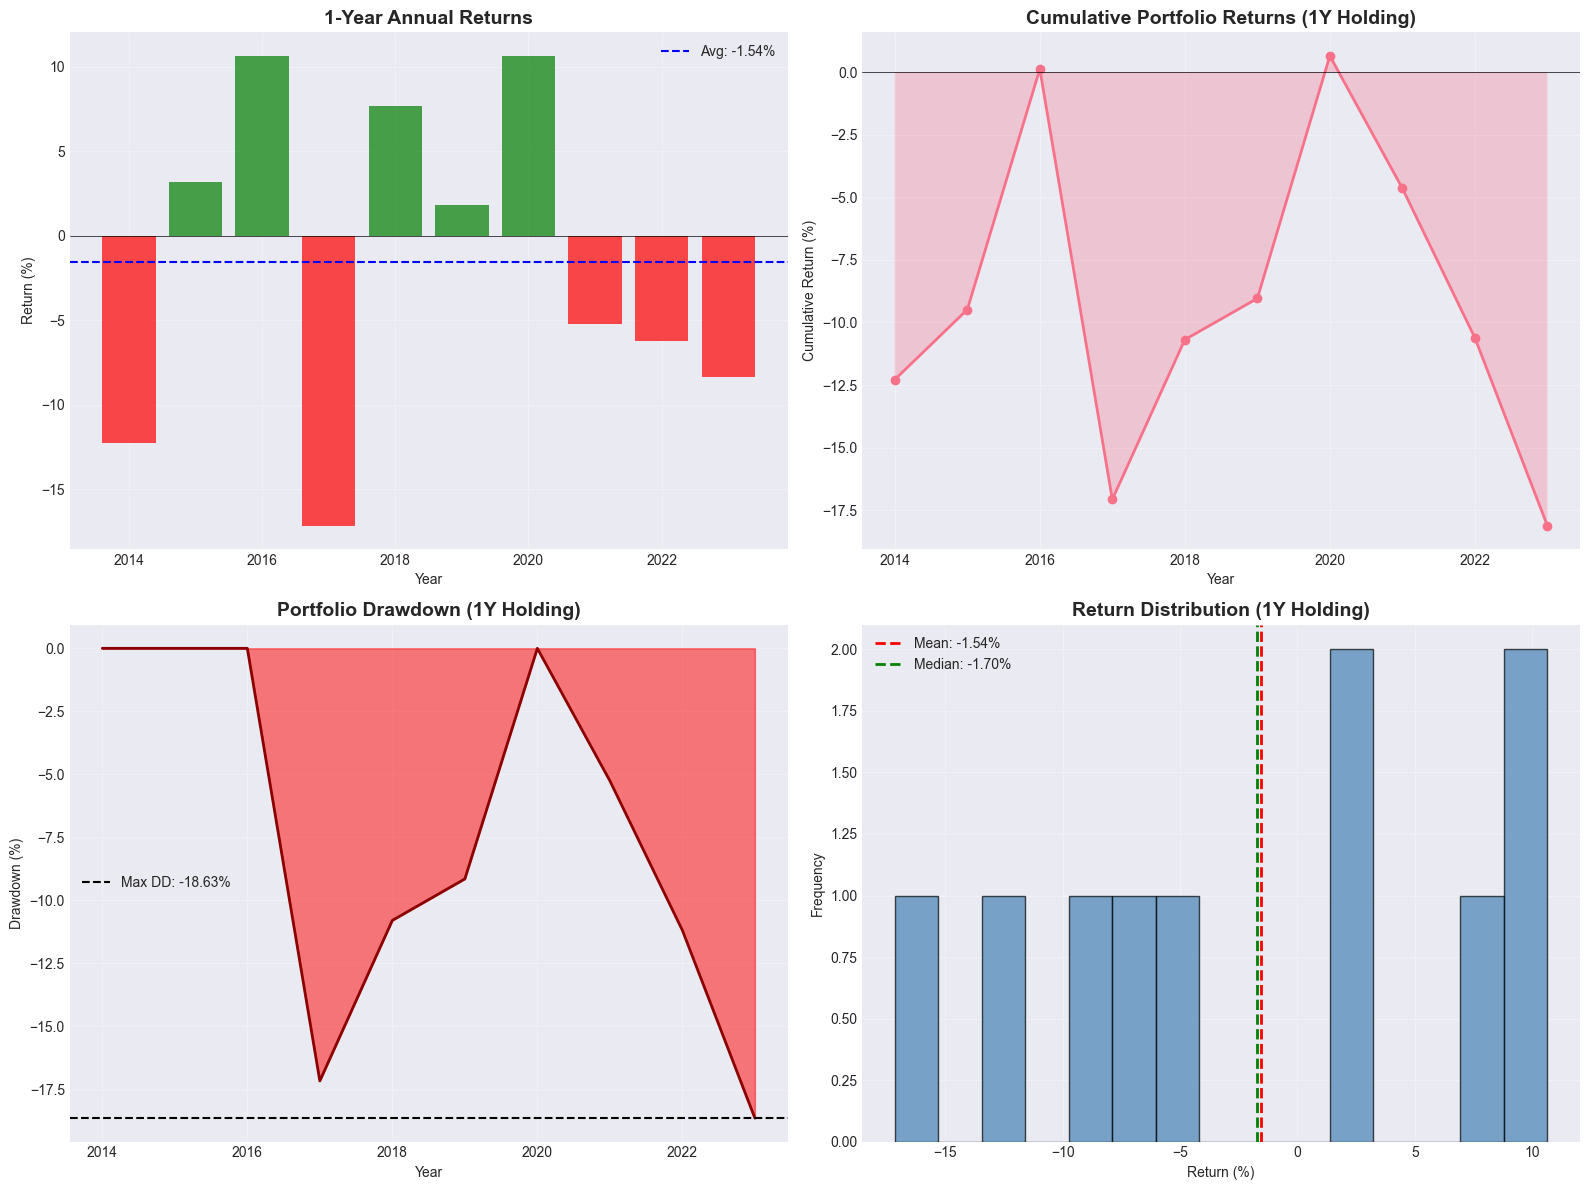


✓ Chart saved as 'backtest_1y_analysis.png'


In [20]:
if len(backtest_1y_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Annual Returns Bar Chart
    ax1 = axes[0, 0]
    colors = ['green' if x > 0 else 'red' for x in backtest_1y_df['Portfolio_Return_%']]
    ax1.bar(backtest_1y_df['Year'], backtest_1y_df['Portfolio_Return_%'], color=colors, alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.axhline(y=backtest_1y_df['Portfolio_Return_%'].mean(), color='blue', linestyle='--', 
                label=f'Avg: {backtest_1y_df["Portfolio_Return_%"].mean():.2f}%')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Return (%)')
    ax1.set_title('1-Year Annual Returns', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Cumulative Returns
    ax2 = axes[0, 1]
    cumulative_1y = calculate_cumulative_returns(backtest_1y_df['Portfolio_Return_%'])
    ax2.plot(backtest_1y_df['Year'], cumulative_1y, marker='o', linewidth=2, markersize=6)
    ax2.fill_between(backtest_1y_df['Year'], cumulative_1y, alpha=0.3)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Cumulative Return (%)')
    ax2.set_title('Cumulative Portfolio Returns (1Y Holding)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 3. Drawdown Chart
    ax3 = axes[1, 0]
    ax3.fill_between(backtest_1y_df['Year'], drawdown_1y, alpha=0.5, color='red')
    ax3.plot(backtest_1y_df['Year'], drawdown_1y, color='darkred', linewidth=2)
    ax3.axhline(y=max_dd_1y, color='black', linestyle='--', 
                label=f'Max DD: {max_dd_1y:.2f}%')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Drawdown (%)')
    ax3.set_title('Portfolio Drawdown (1Y Holding)', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Return Distribution
    ax4 = axes[1, 1]
    ax4.hist(backtest_1y_df['Portfolio_Return_%'], bins=15, color='steelblue', 
             alpha=0.7, edgecolor='black')
    ax4.axvline(backtest_1y_df['Portfolio_Return_%'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {backtest_1y_df["Portfolio_Return_%"].mean():.2f}%')
    ax4.axvline(backtest_1y_df['Portfolio_Return_%'].median(), color='green', 
                linestyle='--', linewidth=2, label=f'Median: {backtest_1y_df["Portfolio_Return_%"].median():.2f}%')
    ax4.set_xlabel('Return (%)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Return Distribution (1Y Holding)', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('backtest_1y_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Chart saved as 'backtest_1y_analysis.png'")

In [21]:
# Backtest with 3-year holding period
backtest_results_3y = []

for year in sorted(strict_results.keys()):
    if year >= 2022:  # Skip if we don't have 3 years ahead data
        continue
    
    tickers = strict_results[year]['CIQ_TICKER'].dropna().tolist()
    
    if len(tickers) == 0:
        continue
    
    portfolio_return, num_stocks = calculate_portfolio_return(
        tickers, year, year + 3, price_df
    )
    
    if portfolio_return is not None:
        # Annualized return
        annualized_return = ((1 + portfolio_return/100) ** (1/3) - 1) * 100
        
        backtest_results_3y.append({
            'Year': year,
            'Holding_Period': '3Y',
            'Stocks_Selected': len(tickers),
            'Stocks_With_Data': num_stocks,
            'Total_Return_%': portfolio_return,
            'Annualized_Return_%': annualized_return
        })

backtest_3y_df = pd.DataFrame(backtest_results_3y)
print("\n" + "="*80)
print("BACKTEST RESULTS: 3-Year Holding Period")
print("="*80)
print(backtest_3y_df.to_string(index=False))

if len(backtest_3y_df) > 0:
    # Calculate max drawdown
    max_dd_3y, drawdown_3y = calculate_max_drawdown(backtest_3y_df['Annualized_Return_%'])
    
    print(f"\nAverage Annualized Return: {backtest_3y_df['Annualized_Return_%'].mean():.2f}%")
    print(f"Median Annualized Return: {backtest_3y_df['Annualized_Return_%'].median():.2f}%")
    print(f"Best Period: {backtest_3y_df['Annualized_Return_%'].max():.2f}%")
    print(f"Worst Period: {backtest_3y_df['Annualized_Return_%'].min():.2f}%")
    print(f"Maximum Drawdown: {max_dd_3y:.2f}%")


BACKTEST RESULTS: 3-Year Holding Period
 Year Holding_Period  Stocks_Selected  Stocks_With_Data  Total_Return_%  Annualized_Return_%
 2014             3Y               12                12       -5.501804            -1.868635
 2015             3Y               10                10      -11.491981            -3.987552
 2016             3Y               16                16      -10.108305            -3.489806
 2017             3Y               16                16       14.522406             4.623719
 2018             3Y               10                10       -9.776977            -3.371377
 2019             3Y                6                 6       15.911195             5.044938
 2020             3Y                9                 8       -0.343694            -0.114696
 2021             3Y               16                16      -31.608614           -11.895018

Average Annualized Return: -1.88%
Median Annualized Return: -2.62%
Best Period: 5.04%
Worst Period: -11.90%
Maximum Drawd

In [22]:
# Backtest with 5-year holding period
backtest_results_5y = []

for year in sorted(strict_results.keys()):
    if year >= 2020:  # Skip if we don't have 5 years ahead data
        continue
    
    tickers = strict_results[year]['CIQ_TICKER'].dropna().tolist()
    
    if len(tickers) == 0:
        continue
    
    portfolio_return, num_stocks = calculate_portfolio_return(
        tickers, year, year + 5, price_df
    )
    
    if portfolio_return is not None:
        # Annualized return
        annualized_return = ((1 + portfolio_return/100) ** (1/5) - 1) * 100
        
        backtest_results_5y.append({
            'Year': year,
            'Holding_Period': '5Y',
            'Stocks_Selected': len(tickers),
            'Stocks_With_Data': num_stocks,
            'Total_Return_%': portfolio_return,
            'Annualized_Return_%': annualized_return
        })

backtest_5y_df = pd.DataFrame(backtest_results_5y)
print("\n" + "="*80)
print("BACKTEST RESULTS: 5-Year Holding Period")
print("="*80)
print(backtest_5y_df.to_string(index=False))

if len(backtest_5y_df) > 0:
    # Calculate max drawdown
    max_dd_5y, drawdown_5y = calculate_max_drawdown(backtest_5y_df['Annualized_Return_%'])
    
    print(f"\nAverage Annualized Return: {backtest_5y_df['Annualized_Return_%'].mean():.2f}%")
    print(f"Median Annualized Return: {backtest_5y_df['Annualized_Return_%'].median():.2f}%")
    print(f"Best Period: {backtest_5y_df['Annualized_Return_%'].max():.2f}%")
    print(f"Worst Period: {backtest_5y_df['Annualized_Return_%'].min():.2f}%")
    print(f"Maximum Drawdown: {max_dd_5y:.2f}%")


BACKTEST RESULTS: 5-Year Holding Period
 Year Holding_Period  Stocks_Selected  Stocks_With_Data  Total_Return_%  Annualized_Return_%
 2014             5Y               12                12      -24.366256            -5.432236
 2015             5Y               10                10       37.233118             6.534871
 2016             5Y               16                16       10.710290             2.055778
 2017             5Y               16                16       45.161405             7.738328
 2018             5Y               10                10      -16.339416            -3.505141
 2019             5Y                6                 6      -11.423425            -2.396863

Average Annualized Return: 0.83%
Median Annualized Return: -0.17%
Best Period: 7.74%
Worst Period: -5.43%
Maximum Drawdown: -5.82%


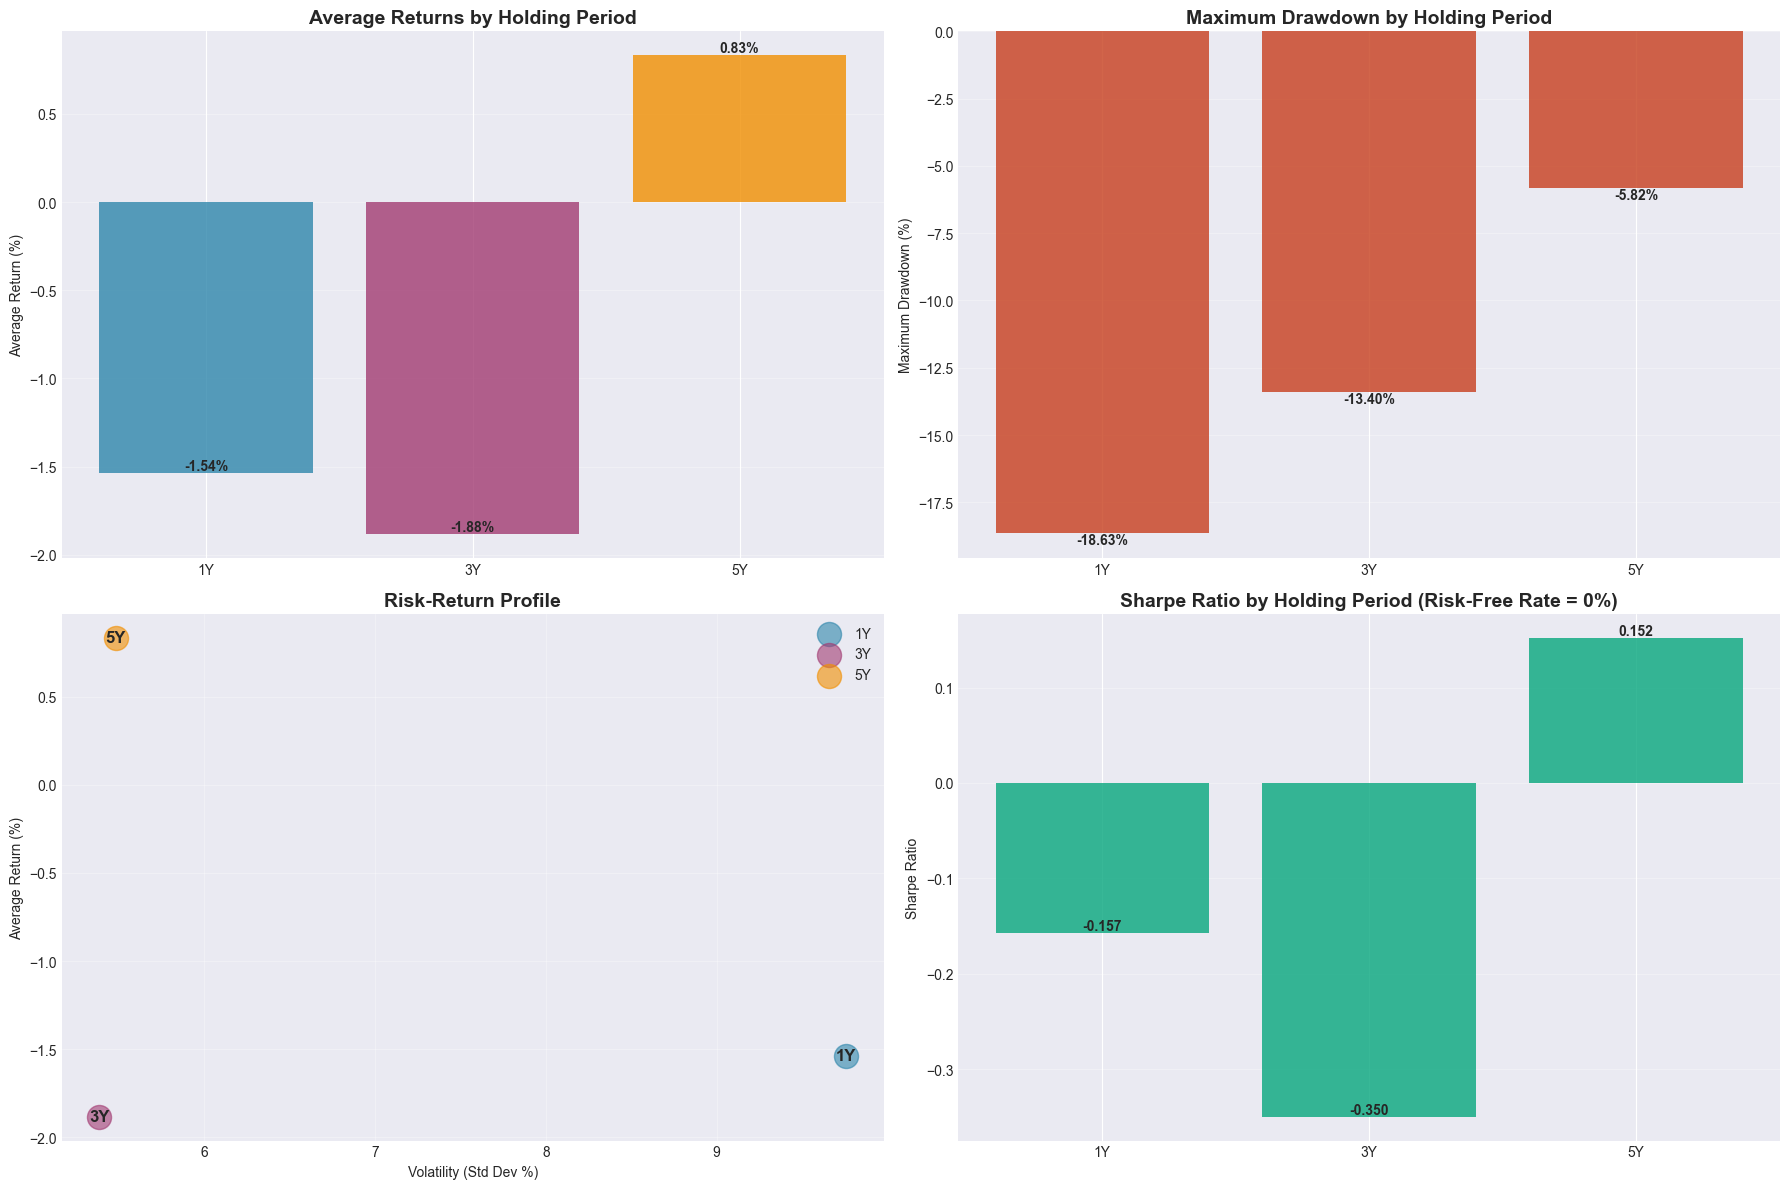


✓ Comparative chart saved as 'backtest_comparative_analysis.png'


In [23]:
# Create comparative charts for all holding periods
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Compare Average Returns
ax1 = axes[0, 0]
holding_periods = []
avg_returns = []
max_dds = []

if len(backtest_1y_df) > 0:
    holding_periods.append('1Y')
    avg_returns.append(backtest_1y_df['Portfolio_Return_%'].mean())
    max_dds.append(max_dd_1y)

if len(backtest_3y_df) > 0:
    holding_periods.append('3Y')
    avg_returns.append(backtest_3y_df['Annualized_Return_%'].mean())
    max_dds.append(max_dd_3y)

if len(backtest_5y_df) > 0:
    holding_periods.append('5Y')
    avg_returns.append(backtest_5y_df['Annualized_Return_%'].mean())
    max_dds.append(max_dd_5y)

x_pos = np.arange(len(holding_periods))
bars = ax1.bar(x_pos, avg_returns, color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(holding_periods)
ax1.set_ylabel('Average Return (%)')
ax1.set_title('Average Returns by Holding Period', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, avg_returns):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. Compare Max Drawdowns
ax2 = axes[0, 1]
bars2 = ax2.bar(x_pos, max_dds, color=['#C73E1D', '#C73E1D', '#C73E1D'], alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(holding_periods)
ax2.set_ylabel('Maximum Drawdown (%)')
ax2.set_title('Maximum Drawdown by Holding Period', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars2, max_dds):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}%', ha='center', va='top' if val < 0 else 'bottom', fontweight='bold')

# 3. Risk-Return Scatter
ax3 = axes[1, 0]
volatilities = []

if len(backtest_1y_df) > 0:
    volatilities.append(backtest_1y_df['Portfolio_Return_%'].std())
if len(backtest_3y_df) > 0:
    volatilities.append(backtest_3y_df['Annualized_Return_%'].std())
if len(backtest_5y_df) > 0:
    volatilities.append(backtest_5y_df['Annualized_Return_%'].std())

colors_scatter = ['#2E86AB', '#A23B72', '#F18F01']
for i, (period, ret, vol) in enumerate(zip(holding_periods, avg_returns, volatilities)):
    ax3.scatter(vol, ret, s=300, alpha=0.6, color=colors_scatter[i], label=period)
    ax3.annotate(period, (vol, ret), ha='center', va='center', fontweight='bold', fontsize=12)

ax3.set_xlabel('Volatility (Std Dev %)')
ax3.set_ylabel('Average Return (%)')
ax3.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Sharpe Ratio Comparison (assuming 0% risk-free rate)
ax4 = axes[1, 1]
sharpe_ratios = [ret / vol if vol > 0 else 0 for ret, vol in zip(avg_returns, volatilities)]
bars4 = ax4.bar(x_pos, sharpe_ratios, color=['#06A77D', '#06A77D', '#06A77D'], alpha=0.8)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(holding_periods)
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Sharpe Ratio by Holding Period (Risk-Free Rate = 0%)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars4, sharpe_ratios):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('backtest_comparative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparative chart saved as 'backtest_comparative_analysis.png'")

In [24]:
# Combine all backtest results and export to Excel
with pd.ExcelWriter('backtest_results_strict_criteria.xlsx', engine='openpyxl') as writer:
    # Export 1-year results
    if len(backtest_1y_df) > 0:
        backtest_1y_df.to_excel(writer, sheet_name='1Y_Holding_Period', index=False)
    
    # Export 3-year results
    if len(backtest_3y_df) > 0:
        backtest_3y_df.to_excel(writer, sheet_name='3Y_Holding_Period', index=False)
    
    # Export 5-year results
    if len(backtest_5y_df) > 0:
        backtest_5y_df.to_excel(writer, sheet_name='5Y_Holding_Period', index=False)
    
    # Create summary sheet with max drawdown
    summary_data = []
    
    if len(backtest_1y_df) > 0:
        summary_data.append({
            'Holding_Period': '1 Year',
            'Avg_Return_%': backtest_1y_df['Portfolio_Return_%'].mean(),
            'Median_Return_%': backtest_1y_df['Portfolio_Return_%'].median(),
            'Best_Return_%': backtest_1y_df['Portfolio_Return_%'].max(),
            'Worst_Return_%': backtest_1y_df['Portfolio_Return_%'].min(),
            'Volatility_%': backtest_1y_df['Portfolio_Return_%'].std(),
            'Max_Drawdown_%': max_dd_1y,
            'Sharpe_Ratio': backtest_1y_df['Portfolio_Return_%'].mean() / backtest_1y_df['Portfolio_Return_%'].std() if backtest_1y_df['Portfolio_Return_%'].std() > 0 else 0,
            'Num_Periods': len(backtest_1y_df)
        })
    
    if len(backtest_3y_df) > 0:
        summary_data.append({
            'Holding_Period': '3 Years (Annualized)',
            'Avg_Return_%': backtest_3y_df['Annualized_Return_%'].mean(),
            'Median_Return_%': backtest_3y_df['Annualized_Return_%'].median(),
            'Best_Return_%': backtest_3y_df['Annualized_Return_%'].max(),
            'Worst_Return_%': backtest_3y_df['Annualized_Return_%'].min(),
            'Volatility_%': backtest_3y_df['Annualized_Return_%'].std(),
            'Max_Drawdown_%': max_dd_3y,
            'Sharpe_Ratio': backtest_3y_df['Annualized_Return_%'].mean() / backtest_3y_df['Annualized_Return_%'].std() if backtest_3y_df['Annualized_Return_%'].std() > 0 else 0,
            'Num_Periods': len(backtest_3y_df)
        })
    
    if len(backtest_5y_df) > 0:
        summary_data.append({
            'Holding_Period': '5 Years (Annualized)',
            'Avg_Return_%': backtest_5y_df['Annualized_Return_%'].mean(),
            'Median_Return_%': backtest_5y_df['Annualized_Return_%'].median(),
            'Best_Return_%': backtest_5y_df['Annualized_Return_%'].max(),
            'Worst_Return_%': backtest_5y_df['Annualized_Return_%'].min(),
            'Volatility_%': backtest_5y_df['Annualized_Return_%'].std(),
            'Max_Drawdown_%': max_dd_5y,
            'Sharpe_Ratio': backtest_5y_df['Annualized_Return_%'].mean() / backtest_5y_df['Annualized_Return_%'].std() if backtest_5y_df['Annualized_Return_%'].std() > 0 else 0,
            'Num_Periods': len(backtest_5y_df)
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print("\n" + "="*80)
print("✓ Backtest results exported to 'backtest_results_strict_criteria.xlsx'")
print("="*80)
print("  - Summary: Overall performance metrics (including Max Drawdown & Sharpe Ratio)")
print("  - 1Y_Holding_Period: Year-by-year 1-year returns")
print("  - 3Y_Holding_Period: 3-year period returns")
print("  - 5Y_Holding_Period: 5-year period returns")
print("\n" + "="*80)
print("SUMMARY RESULTS")
print("="*80)
print(summary_df.to_string(index=False))


✓ Backtest results exported to 'backtest_results_strict_criteria.xlsx'
  - Summary: Overall performance metrics (including Max Drawdown & Sharpe Ratio)
  - 1Y_Holding_Period: Year-by-year 1-year returns
  - 3Y_Holding_Period: 3-year period returns
  - 5Y_Holding_Period: 5-year period returns

SUMMARY RESULTS
      Holding_Period  Avg_Return_%  Median_Return_%  Best_Return_%  Worst_Return_%  Volatility_%  Max_Drawdown_%  Sharpe_Ratio  Num_Periods
              1 Year     -1.536613        -1.704844      10.647274      -17.159579      9.759756      -18.633673     -0.157444           10
3 Years (Annualized)     -1.882303        -2.620006       5.044938      -11.895018      5.384204      -13.400803     -0.349597            8
5 Years (Annualized)      0.832456        -0.170543       7.738328       -5.432236      5.480780       -5.817990      0.151886            6
